# Отчет о решении задачи "Моделирование вкладов физических лиц"

## Data Analysis

Проведем первичный анализ данных.

Для начала конвертируем excel таблицу в формат csv.

Ссылка на ресурс, откуда взят код: https://www.penwatch.net/cms/excel_to_csv/

In [1]:
import xlrd
import unicodecsv

def xls2csv (xls_filename, csv_filename):
    # Converts an Excel file to a CSV file.
    # If the excel file has multiple worksheets, only the first worksheet is converted.
    # Uses unicodecsv, so it will handle Unicode characters.
    # Uses a recent version of xlrd, so it should handle old .xls and new .xlsx equally well.

    wb = xlrd.open_workbook(xls_filename)
    sh = wb.sheet_by_index(0)

    fh = open(csv_filename,"wb")
    csv_out = unicodecsv.writer(fh, encoding='utf-8')

    for row_number in xrange (sh.nrows):
        csv_out.writerow(sh.row_values(row_number))

    fh.close()

In [2]:
xls2csv ('Data.xlsx', 'Data_csv.csv')

Импортируем некоторые необходимые модули.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

Считаем полученные данные и посмотрим на их размер.

In [4]:
df = pd.read_csv('Data_csv.csv')

In [5]:
df.shape

(84, 12)

In [6]:
df.head()

,Unnamed: 0,Прирост вкладов физических лиц в рублях (млн руб),Доходность ОФЗ по сроку до 1 года,Ключевая ставка,Ставка по вкладам в долларах до 1 года,Ставка по вкладам в рублях до 1 года,"Нефть марки Юралс, долл./барр","Индекс потребительских цен, ед.","М0, руб","М2, руб","Курс доллара к рублю, руб","Номинальная средняя з/п, руб"
0,40544.0,-79049.0,5.244667,7.75,2.9,4.5,96.29,106.17151,5532900.0,19307.7,30.08,20669.0
1,40575.0,180475.0,5.144211,8.00,3.1,4.4,103.96,106.99964,5613700.0,19536.7,29.29,20680.0
2,40603.0,106845.0,5.021364,8.00,3.1,4.2,114.44,107.66304,5647000.0,19788.7,28.43,22673.0
3,40634.0,224890.0,4.558571,8.00,2.6,4.1,123.15,108.12599,5863400.0,20020.8,28.10,22519.0
4,40664.0,45856.0,4.795000,8.25,2.6,4.1,114.46,108.64500,5893400.0,20160.9,27.87,22779.0


Изменим названия колонок, чтобы с ними было удобнее работать.

In [7]:
df.columns = ['date', 'dep_incr', 'ofz_yield', 'key_rate', 'dep_rate_dollars', 'dep_rate_rubles', 'urals_oil', 'cons_pr_index', 'm0', 'm2', 'dollar_rate', 'nom_avrg_salary']

При считывании данных колонка с датой преобразовалась в непривычный для восприятия формат. Данные числа (40544, 40575 и т.д.) являются ни чем иным, как количеством дней, прошедших с 01.01.1900. Поэтому можно оставить их в таком виде.

In [8]:
df.head()

,date,dep_incr,ofz_yield,key_rate,dep_rate_dollars,dep_rate_rubles,urals_oil,cons_pr_index,m0,m2,dollar_rate,nom_avrg_salary
0,40544.0,-79049.0,5.244667,7.75,2.9,4.5,96.29,106.17151,5532900.0,19307.7,30.08,20669.0
1,40575.0,180475.0,5.144211,8.00,3.1,4.4,103.96,106.99964,5613700.0,19536.7,29.29,20680.0
2,40603.0,106845.0,5.021364,8.00,3.1,4.2,114.44,107.66304,5647000.0,19788.7,28.43,22673.0
3,40634.0,224890.0,4.558571,8.00,2.6,4.1,123.15,108.12599,5863400.0,20020.8,28.10,22519.0
4,40664.0,45856.0,4.795000,8.25,2.6,4.1,114.46,108.64500,5893400.0,20160.9,27.87,22779.0


Выделим целевой признак - прирост вкладов физических лиц в рублях (млн руб).

In [9]:
y = df.dep_incr
X = df.drop(columns=['dep_incr'])

Взглянем на попарные корреляции признаков.

Больше всего целевой признак dep_incr коррелирует с norm_avrg_salary (номинальная средняя з/п), менее всего - с признаками ofz_yield (доходность ОФЗ по сроку до 1 года), deep_rate_dollars (ставка по вкладам в долларах), urals_oil (нефть марки Юралс).

В выборке есть признаки, коррелирующие с целевым, а значит, задачу можно решать линейными методами.

In [10]:
dfc = X.corrwith(y)
print dfc

date                0.092411
ofz_yield          -0.017400
key_rate            0.016667
dep_rate_dollars   -0.034415
dep_rate_rubles     0.025006
urals_oil          -0.068321
cons_pr_index       0.102976
m0                  0.186576
m2                  0.146645
dollar_rate         0.080033
nom_avrg_salary     0.422435
dtype: float64


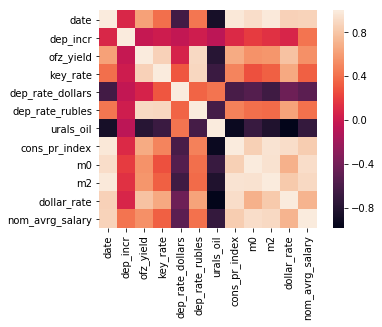

In [11]:
sb.heatmap(df.corr(), square=True)

Посмотрим средние признаков, чтобы оценить их масштаб.

In [12]:
np.mean(df)

date                4.180660e+04
dep_incr            1.514771e+05
ofz_yield           7.875670e+00
key_rate            9.130952e+00
dep_rate_dollars    2.184643e+00
dep_rate_rubles     6.233929e+00
urals_oil           8.311810e+01
cons_pr_index       1.367257e+02
m0                  7.806555e+06
m2                  3.010574e+04
dollar_rate         4.528869e+01
nom_avrg_salary     3.187713e+04
dtype: float64

Признаки имеют разный масштаб, значит для дальнейшей работы нам лучше нормировать матрицу объекты-признаки.

In [13]:
from sklearn.preprocessing import scale
from sklearn.utils import shuffle

In [14]:
df_shuffled = shuffle(df, random_state=123)
X_scaled = scale(df_shuffled.drop(columns=['dep_incr']))
y_scaled = df_shuffled.dep_incr

Разделим данные на обучающую и тестовую выборки.

In [15]:
from sklearn.model_selection import train_test_split

(X_train, X_test, y_train, y_test) = train_test_split(X_scaled, y_scaled, test_size=0.3, shuffle=True)

## Linear Regression

В качестве наивного base-line решения построим и обучим модель линейной регрессии.

In [16]:
from sklearn.linear_model import LinearRegression
from sklearn import metrics

In [17]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

Посмотрим на веса признаков.

In [18]:
zip(df.columns, lr_model.coef_)

[('date', -987476.8991127176),
 ('dep_incr', -195362.22023182808),
 ('ofz_yield', 127407.80979338066),
 ('key_rate', 119144.70998658999),
 ('dep_rate_dollars', -91534.558725720824),
 ('dep_rate_rubles', 156395.18780673723),
 ('urals_oil', 979998.58686072077),
 ('cons_pr_index', 390320.30034874578),
 ('m0', -496782.87208244315),
 ('m2', 124379.77447185494),
 ('dollar_rate', 451291.17794816312)]

Мы видим, что веса при некоторых признаках по модулю значительно больше, чем при других.

В качестве метрики качества будем использовать rmse.

In [19]:
from sklearn.metrics import mean_squared_error

def rmse(y_actual, y_predicted):
    return np.sqrt(mean_squared_error(y_actual, y_predicted))

Найднем значение rmse на тестовой выборке.

In [20]:
y_pred = lr_model.predict(X_test)

In [21]:
print rmse(y_test, y_pred)

273901.070351


Найднем значение rmse ошибки на обучающей выборке.

In [22]:
y_pred = lr_model.predict(X_train)

In [23]:
print rmse(y_train, y_pred)

141495.066693


Два этих значения довольно велики. Постараемся минимизировать их, а также решить проблему мультиколлинеарности при помощи Lasso и Ridge регрессоров.

## Lasso Regression

In [24]:
from sklearn.linear_model import Lasso

In [25]:
lasso_regressor = Lasso()
lasso_regressor.fit(X_train, y_train)
zip(df.columns, lasso_regressor.coef_)

[('date', -708932.5326810031),
 ('dep_incr', -218407.66805683207),
 ('ofz_yield', 144732.53165031003),
 ('key_rate', 113517.06893628769),
 ('dep_rate_dollars', -79804.309745871273),
 ('dep_rate_rubles', 144299.61291559931),
 ('urals_oil', 743874.33665746695),
 ('cons_pr_index', 303043.73726123915),
 ('m0', -517616.32373422245),
 ('m2', 140609.76213285138),
 ('dollar_rate', 486846.86496879131)]

Результат на тестовой выборке:

In [26]:
y_pred = lasso_regressor.predict(X_test)

In [27]:
print rmse(y_test, y_pred)

279224.131199


Результат на обучающей выборке:

In [28]:
y_pred = lasso_regressor.predict(X_train)

In [29]:
print rmse(y_train, y_pred)

141788.405352


К сожалению, значительного улучшения не наблюдается. Давайте посмотрим, как справится Ridge регрессор.

## Ridge Regression

In [30]:
from sklearn.linear_model import Ridge

In [31]:
ridge_regressor = Ridge()
ridge_regressor.fit(X_train, y_train)
zip(df.columns, ridge_regressor.coef_)

[('date', -169261.17642391805),
 ('dep_incr', -180525.4795240743),
 ('ofz_yield', 139125.00459943042),
 ('key_rate', 88252.761045576975),
 ('dep_rate_dollars', -48527.764995506986),
 ('dep_rate_rubles', 31609.830362162418),
 ('urals_oil', -14343.8733039864),
 ('cons_pr_index', -22888.164137844738),
 ('m0', -124900.78807568805),
 ('m2', 114964.51816115589),
 ('dollar_rate', 476615.19028157403)]

In [32]:
y_pred = ridge_regressor.predict(X_test)

In [33]:
print rmse(y_test, y_pred)

244362.694623


In [34]:
y_pred = ridge_regressor.predict(X_train)

In [35]:
print rmse(y_train, y_pred)

150930.925945


Значение ошибки по-прежнему велико.

## Random Forest Regressor

Посмотрим, какие результаты покажет случайный лес.

In [36]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

Подберем оптимальные параметры при помощи сетки.

In [37]:
param_grid = {'n_estimators': [4,6,8,10], 'criterion': ['mse'], 'max_features': ['auto', 'sqrt', 'log2'],
              'max_depth': [3, 4, 5], 'min_samples_split': [4,5,6,8], 'min_samples_leaf': [1, 2, 3, 4]}

regr = RandomForestRegressor()
optimizer = GridSearchCV(regr, param_grid, cv=4)
optimizer.fit(X_train, y_train)

GridSearchCV(cv=4, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'min_samples_leaf': [1, 2, 3, 4], 'n_estimators': [4, 6, 8, 10], 'min_samples_split': [4, 5, 6, 8], 'criterion': ['mse'], 'max_features': ['auto', 'sqrt', 'log2'], 'max_depth': [3, 4, 5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [38]:
print optimizer.best_params_

{'min_samples_leaf': 2, 'n_estimators': 10, 'min_samples_split': 5, 'criterion': 'mse', 'max_features': 'auto', 'max_depth': 5}


In [39]:
y_pred = optimizer.predict(X_test)

In [40]:
rmse(y_pred, y_test)

222471.7235805573

In [41]:
y_pred = optimizer.predict(X_train)

In [42]:
rmse(y_pred, y_train)

160518.73186313323

## XGBoost

Построим и обучим xgboost модель в качестве кандидата на основное решение.

In [43]:
import os
mingw_path = 'C:\\Program Files\\mingw-w64\\x86_64-7.3.0-posix-seh-rt_v5-rev0\\mingw64\\bin'
os.environ['PATH'] = mingw_path + ';' + os.environ['PATH']
import xgboost as xgb

Нам понадобится отделить от обучающей выборки некоторую часть для валидации.

In [44]:
(X_train, X_valid, y_train, y_valid) = train_test_split(X_train, y_train, test_size=0.3, shuffle=True)

In [45]:
X_train.shape

(40L, 11L)

In [46]:
X_valid.shape

(18L, 11L)

In [47]:
X_test.shape

(26L, 11L)

In [48]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dvalid = xgb.DMatrix(X_valid, label=y_valid)
dtest = xgb.DMatrix(X_test)
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

Подберем соответствующим образом параметры.

In [49]:
xgb_par = {'learning_rate': 1, 'min_child_weight': 10, 'eta': 0.9, 'colsample_bytree': 0.5, 'max_depth': 4,
            'subsample': 0.9, 'lambda': 2.0, 'nthread': -1, 'silent': 1,
            'eval_metric': 'rmse', 'objective': 'reg:linear', 'gamma': 0.1}

In [50]:
xgb_model = xgb.train(xgb_par, dtrain, 100, watchlist, early_stopping_rounds=50, maximize=False, verbose_eval=20)

[0]	train-rmse:220975	valid-rmse:373442
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[20]	train-rmse:92155.1	valid-rmse:245828
[40]	train-rmse:49251.8	valid-rmse:218280
[60]	train-rmse:29615.9	valid-rmse:213667
[80]	train-rmse:19121.2	valid-rmse:211206
[99]	train-rmse:13720.5	valid-rmse:204046


In [51]:
y_pred = xgb_model.predict(dtest)

In [52]:
print rmse(y_test, y_pred)

348207.463769


In [53]:
y_pred = xgb_model.predict(dtrain)

In [54]:
print rmse(y_train, y_pred)

13720.5061641


XGBoost также не привнес какого-либо улучшения результатов. Возможно, это связано с недостаточным размером данных для обучения.

Таким образом, наилучшим решением остается использование случайного леса или линейной модели с регуляризатором.